<a href="https://colab.research.google.com/github/VSCHY/RiverNetwork/blob/master/Toy_Model_Large_basin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Description of the toy model </h1>
<hr>

<center>

![image](https://drive.google.com/uc?export=view&id=1TAd3t-rDnwhBaIuISNdxclXb4WLElJsz)

<em>Figure 1: Description of the HTUs toy model in series </em>
</center>

River dynamic Parameter : 
*   tcst : time constant of the reservoir
*   topoindex

In this model we consider a basic time unit = 1. Then the subdivision of the time unit are defined by subdt. For exemple, subdt = 2 corresponds to two time step inside the basic unit, i.e. a time step of 0.5.

Time parameters :
*   niter : number of iteration
*   subdt : number of subdivision of 1 time unit

Formula to define the discharge out of i : 

Qi = 1/(tcst*topoindex)*Vi * dt

The outflow discharge is Qout = Qnhtus

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class experiment:
  def __init__(self, D, V= None, Qin = 0):
    """
    D : Initialization of the parameters values from the dictionnary
    V : Array with the initial state of the different reservoir (possible to describe as a list)
    Qin : inflow in the first reservoi
    """
    self.tcst = D["tcst"]
    self.topoindex = D["topoindex"]
    self.nhtus = D["nhtus"]
    # 
    self.subdt =D["subdt"]
    # subdt describe the time step, it is the number of division of the basic time step   
    self.dt = 1/self.subdt
    # 
    self.niter = D["niter"] 
    self.f_cst = 1/(self.tcst * self.topoindex)
    self.init_var()
    if V is not None:
        self.V[:] = V
    self.Qin = Qin

  def init_var(self):
    """
    Initialization of volume and discharge for each reservoir
    """
    self.V = np.zeros((self.nhtus))
    self.Q = np.zeros((self.nhtus))  
  
  def launch(self, volume_hist = False):
     """
     Run the experiment, the output are the mean discharge over each basic unit of time
     and for each iteration
     """
     if volume_hist: hist_V = np.zeros((self.nhtus, self.subdt*self.niter))
     hist_out = np.zeros(self.subdt*self.niter)
     for it in range(self.niter):
        for t in range(self.subdt):
          if volume_hist: hist_V[:, it * self.subdt + t] = self.V[:]
          temp = np.zeros((2,self.V.shape[0]))
          temp[0,:] = self.V*self.f_cst*self.dt; temp[1,:] = self.V
          self.Q = np.min(temp, axis = 0)

          self.V = self.V-self.Q
          hist_out[it * self.subdt + t] = self.Q[-1]
          self.V[1:] += self.Q[:-1]
          self.V[0] += self.Qin

     # Mean de subdt sur les subdt
     hist_out = np.mean(np.reshape(hist_out, (-1,self.subdt)), axis = 1)
     if volume_hist: 
        hist_V = np.mean(np.reshape(hist_V, (self.nhtus,-1,self.subdt)), axis = 2)
        return hist_out, hist_V
     else:
        return hist_out

####

def get_param(tcst = 0.0035, topoindex = 300, nhtus = 1, subdt = 1, niter = 1000):
    """
    Function to define the Dictionnary parameters.
    This is simplified by using default values.
    """
    D = {"tcst": tcst, "topoindex":topoindex, "nhtus" :nhtus, "subdt":subdt,  "niter":niter}
    return D

<h1> Large river example </h1>
<hr>
Let's consider a large river with a regular decomposition in HTUs :
the length of the river is 3000km with a 4 km difference of altitude. 
The topoindex is adjusted to the number of HTUs considered. 

In this first example we consider a subdt = 3, tcst = 0.035 and a number of htus between 2000 and 9000.

In [2]:
# Functions for the experiments

# Qinit = V*1/(self.tcst * self.topoindex)*dt
# 30 000 * self.tcst * self.topoindex / dt  = V 
def get_config(length = 3000, dz = 4, tcst = 0.035, subdt = 3, niter = 4000):
  config = {"length" : length, "dz" : dz, "tcst" : tcst, "subdt" : subdt, "niter" : niter}
  return config

def make_experiment(config, Lnhtus):
  Lout = []
  for nhtus in Lnhtus:
      topoindex = config["length"]/nhtus/np.sqrt((config["dz"]/config["length"]))
      # Qinit = V0*1/(self.tcst * self.topoindex)*dt
      Qinit = 3000 
      V0 =  Qinit * config["tcst"] * topoindex * config["subdt"] 
      exp0 = experiment(get_param(subdt = config["subdt"],  topoindex = topoindex, tcst = config["tcst"], nhtus = nhtus, niter = config["niter"]), [V0]*nhtus)
      Lout.append(exp0.launch());
  return Lout

<h2> First part </h2>
We take subdt = 3. The volume are set at equelibrium for a Qin = 1000.
At t=0 we set Qin = 0 -> let see how the htus will empty

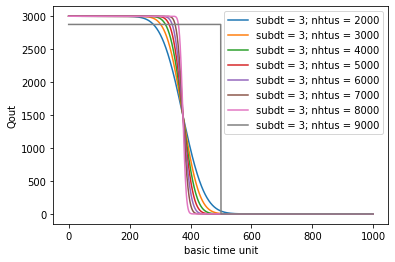

In [3]:
# With the default setup
Lnhtus = np.arange(2000,10000,1000)

config = get_config()
Lout = make_experiment(config, Lnhtus)

for i in range(len(Lout)):
    plt.plot(Lout[i][2500:3500], label = "subdt = 3; nhtus = {0}".format(Lnhtus[i]))
plt.ylabel("Qout")
plt.xlabel("basic time unit")
plt.legend()
plt.show()


<h4> Conclusion </h4>

The simulations have a different behaviour, the higher the number of HTUs the later the reaction to Qin = 0 at t = 0.

At some point the evolution of Qout is unstable, such as with nhtus = 9000.

<h2> Second part </h2>

We consider :

*   the time T1 required to reach Qout = 2500 $m^3/s$
*   the time T2 required to reach Qout = 500 $m^3/s$

We then observe the relaxation time $\Delta T = T2-T1$



In [4]:
# Preparation 

def get_deltaT(subdt, Lnhtus, **kwargs):
  config = get_config(subdt = subdt, **kwargs)
  Lout = make_experiment(config, Lnhtus)
  d1 = np.array([np.argmin(np.abs(Lout[i][:]-2500)) for i in range(len(Lout))])
  d2 = np.array([np.argmin(np.abs(Lout[i][:]-500)) for i in range(len(Lout))])
  out = [d2[i]-d1[i] for i in range(len(Lout))]
  return out

Start running
subdt: 3
subdt: 5


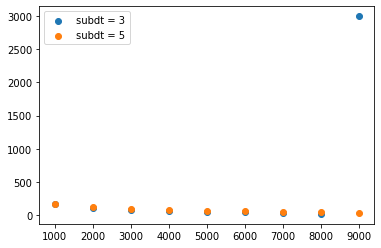

In [5]:
# First try

DeltaT = {}
Lnhtus = np.arange(1000,10000,1000)
print("Start running")
for subdt in [3,5]: 
  print("subdt: {0}".format(subdt))
  DeltaT[subdt] = get_deltaT(subdt = subdt, Lnhtus = Lnhtus)

for subdt in [3, 5]:
  plt.scatter(Lnhtus, DeltaT[subdt], label = "subdt = {0}".format(subdt))
plt.legend()
plt.show()

Both simulations are really close one to another except for subdt = 3 and nhtus = 9000. This example is unstable, it has an abrubt change and thus a $\Delta t = 0 $. This unstability is resolved at a lower timestep, at subdt = 5. 

For the following experiences we may limit nhtus to 8000, to avoid this issue.

  0%|          | 0/6 [00:00<?, ?it/s]

Start running
subdt: 3


 17%|█▋        | 1/6 [00:05<00:29,  5.89s/it]

subdt: 5


 33%|███▎      | 2/6 [00:23<00:37,  9.27s/it]

subdt: 7


 50%|█████     | 3/6 [00:51<00:45, 15.04s/it]

subdt: 9


 67%|██████▋   | 4/6 [01:27<00:42, 21.32s/it]

subdt: 10


 83%|████████▎ | 5/6 [02:06<00:26, 26.76s/it]

subdt: 12


100%|██████████| 6/6 [02:53<00:00, 29.00s/it]


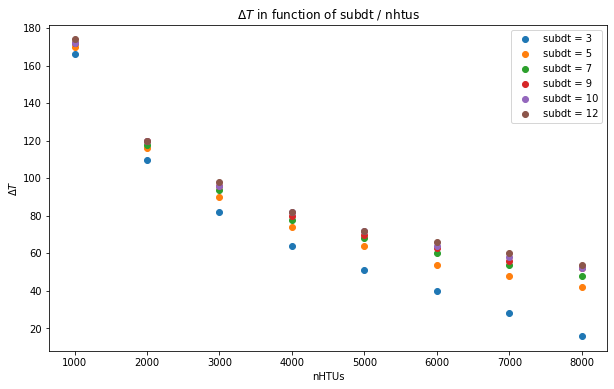

In [6]:
import tqdm

DeltaT = {}
Lnhtus = np.arange(1000,9000,1000)
Lsubdt = [3,5, 7, 9, 10, 12]

print("Start running")
for subdt in tqdm.tqdm(Lsubdt): 
  print("subdt: {0}".format(subdt))
  DeltaT[subdt] = get_deltaT(subdt = subdt, Lnhtus = Lnhtus)

##############################

fig = plt.figure(figsize = (10, 6))
#
for subdt in Lsubdt:
  plt.scatter(Lnhtus, DeltaT[subdt], label = "subdt = {0}".format(subdt))
plt.legend()
plt.xlabel("nHTUs")
plt.ylabel("$\Delta T$")
plt.title("$\Delta T$ in function of subdt / nhtus")
plt.show()

<h4> Conclusion </h4>

**Impact of nhtus**

*   The higher the number of htus, the higher $\Delta t$, thus, the more diffusive is the river system.

**Impact of subdt**

*   An higher subdt means that the main time unit is more divided and thus we have a smaller time step. The smaller the time step, the higher $\Delta t$, thus, the more diffusive the river system.

**In a real river system**

We may consider that in a real system we have many different variations interactig with the river dynamic. Although they react more slowly, the more diffusive configurations reacts first. ($\Delta t$ is larger but the variation starts earlier). Thus, high number of HTUs lower the sensibility of the river networks to discharge change. At a certain point, the river network will be too slow to react and then we may have a almost constant discharge.

The same thing may happen with a too low subdt.

Of course this issue will depend on the chosen time constant and the topography of the catchment (here represented as length and dz).


<h2> Third part </h2>
Sensibility to the slope.

  0%|          | 0/6 [00:00<?, ?it/s]

Start running


100%|██████████| 6/6 [00:17<00:00,  2.91s/it]


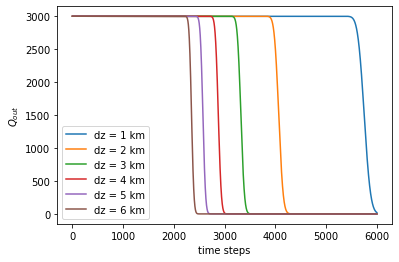

In [7]:
# First try: time serie

TS = {}
Lnhtus = [3000]
subdt = 5
Ldz = np.arange(1,7)

print("Start running")
for dz in tqdm.tqdm(Ldz): 
  config = get_config(subdt = subdt, dz = dz, niter = 6000)
  TS[dz] = make_experiment(config, Lnhtus)
  TS[dz] = np.round(np.array(TS[dz][0]),2)

for dz in Ldz:
  plt.plot(TS[dz][:], label = "dz = {0} km".format(dz))
plt.xlabel("time steps")
plt.ylabel("$Q_{out}$")
plt.legend()
plt.show()

As expected, the higher $dz$, the higher is the reaction time.

  0%|          | 0/6 [00:00<?, ?it/s]

Start running
subdt: 5


 17%|█▋        | 1/6 [01:00<05:04, 60.83s/it]

subdt: 5


 33%|███▎      | 2/6 [02:16<04:21, 65.37s/it]

subdt: 5


 50%|█████     | 3/6 [03:39<03:31, 70.64s/it]

subdt: 5


 67%|██████▋   | 4/6 [04:49<02:20, 70.50s/it]

subdt: 5


 83%|████████▎ | 5/6 [05:47<01:06, 66.63s/it]

subdt: 5


100%|██████████| 6/6 [06:33<00:00, 65.64s/it]


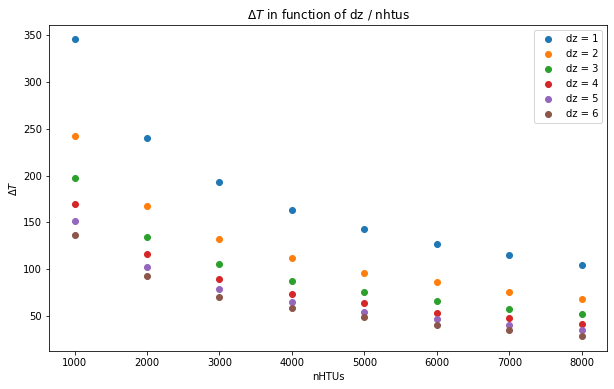

In [10]:
DeltaT = {}
Lnhtus = np.arange(1000,9000,1000)
# Lsubdt = [3,5, 7, 9, 10, 12]
subdt = 5
Ldz = np.arange(1,7)
print("Start running")
for dz in tqdm.tqdm(Ldz): 
  print("subdt: {0}".format(subdt))
  DeltaT[dz] = get_deltaT(subdt = subdt, Lnhtus = Lnhtus, dz = dz, niter = 10000)

##############################

fig = plt.figure(figsize = (10, 6))
#
for dz in Ldz:
  plt.scatter(Lnhtus, DeltaT[dz], label = "dz = {0}".format(dz))
plt.legend()
plt.xlabel("nHTUs")
plt.ylabel("$\Delta T$")
plt.title("$\Delta T$ in function of dz / nhtus")
plt.show()

For each $dz$, we find the same relationship of $\Delta t$ decreasing as nHTUs raise.

These differences of $\Delta t$ are exacerbated as the value $dz$ decrease:


*   $dz$ = 1 :$\Delta t$ = 350 for nHTUs = 1000 / $\Delta t$ = 150 for nHTUs = 8000
*   $dz$ = 6 :$\Delta t$ = 150 for nHTUs = 1000 / $\Delta t$ = 50 for nHTUs = 8000


This is why we may conclude that these issues are more important in flatter basins. 